# SCode

In [1]:
from sys import version
print(f'Python {version}')

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


# Reference Data

In [2]:
importance_classes = ['I', 'II', 'III', 'IV']

importance_class_dict = {
  'I': 'Civil protection - buildings and structures essential for civil protection.',
  'II':	'High consequences in case of failure - buildings and structures of high importance to the society.',
  'III':	'Ordinary - structures of ordinary importance and not classified as A, B and D.',
  'IV':	'Minor or temporary structures - structures of minor importance for public safety and temporary structures.'
}

importance_factor_dict = {
  'I': 1.7,
  'II': 1.4,
  'III': 1.0,
  'IV': None
  }

# New Code Functions

In [3]:
from math import pi, log, log10, exp, tan, sin, cos, atan2, isclose
from itertools import accumulate


def interp(x, x1, x2, y1, y2):
    if y1 is None or y2 is None:
        return None
    elif x1 == x2:
        return 0.5 * (y1 + y2)
    else:
        return y1 + (x - x1) / (x2 - x1) * (y2 - y1)


def list_interp(val, list_1, list_2):
    """
    Returns an interpolated value based on a list of reference values and a list of target values
    val is the lookup value
    list_1 is the lookup list
    list_2 is the result list with values corresponding to those on list_1
    """
    i_list = [i for i, n in enumerate(list_1) if n == val]
    if i_list:
        return list_2[i_list[0]]
    elif val <= list_1[0]:
        return list_2[0]
    elif val >= list_1[-1]:
        return list_2[-1]
    else:
        index_list = [i for i, (x1, x2) in enumerate(zip(list_1[:-1], list_1[1:])) if val >= x1 and val <= x2]
        if len(index_list) == 1:
            j = index_list[0]
            return interp(val, list_1[j], list_1[j+1], list_2[j], list_2[j+1])
        else:
            return None


def exceedance2return(exceedance_probability, period=50):
  """Returns the return period for ground motion with the given probability of
  being exceeded over the period considered. For example, the return period 
  for a ground motion with a 10% probability of being exceeded in 50 years
  is around 475 years. 
  >>> isclose(exceedance2return(exceedance_probability=0.1, period=50), 474.56107905149526)
  True
  >>> isclose(exceedance2return(exceedance_probability=0.2, period=50), 224.07100588622754)
  True
  """
  return - period / log(1 - exceedance_probability)


def return2exceedance(return_period, period=50):
  """Returns the probability of a ground motion being exceeded over a period  
  when given a ground motion return period. For example, the probability of a  
  ground motion with return period of 475 years being exceeded over a time  
  period of 50 years is around 10%. 
  >>> isclose(return2exceedance(return_period=475, period=50), 0.09991237374774076)
  True
  >>> isclose(return2exceedance(return_period=225, period=50), 0.19926259708319194)
  True
  """
  return 1 - exp(-period/return_period)


def PGA2S475(a_g_475):
  """"Returns the (S_1, S_s) tuple for a reference PGA.
  Reference: 15WCEE, 'Deriving S_s and S_1 parameters from PGA maps'
  """
  def S_s_calc(PGA): return 0.3386 * PGA + 2.1696
  def S_1_calc(PGA): return 0.5776 * PGA + 0.5967
  return {'S_s':S_s_calc(a_g_475), 'S_1':S_1_calc(a_g_475)}


def S_calc(S_s_475, S_1_475, T):
  """"Returns the (S_1, S_s) tuple for a given return period based on a 
  reference PGA and reference return period.
  Reference: 15WCEE, 'Deriving S_s and S_1 parameters from PGA maps'
  """
  def S_calc(S_475, k, T): return S_475 * (T / 475)**k
  S_s_475_S_keys = (0.20, 0.55, 0.90, 1.20, 1.50)
  S_s_475_k_vals = (0.46, 0.42, 0.39, 0.35, 0.30)
  S_1_475_S_keys = (0.01, 0.02, 0.05, 0.10, 0.20)
  S_1_475_k_vals = (0.40, 0.40, 0.40, 0.40, 0.40)
  k_s = list_interp(S_s_475, S_s_475_S_keys, S_s_475_k_vals)
  S_s = S_calc(S_s_475, k_s, T)
  k_1 = list_interp(S_1_475, S_1_475_S_keys, S_1_475_k_vals)
  S_1 = S_calc(S_1_475, k_1, T)
  return {'S_s':S_s, 'S_1':S_1, 'k_s':k_s, 'k_1':k_1}


def get_importance_factor(importance_class):
  """Returns the Importance factor I_E"""
  return importance_factor_dict.get(importance_class)

def get_v_s(N, weathering=True):
  """"""
  return 113*N**0.27 if weathering else 121*N**0.19

def get_v_s_30(descending_list_of_tuples_of_thickness_and_v_s):
  """"""
  depth = 0
  d_v = 0
  #print('   d_i, depth, v_s_i, d/v_s,  d_v')
  for d_i, v_s_i in descending_list_of_tuples_of_thickness_and_v_s:
    if depth + d_i >= 30:
      d_i = 30 - depth
      d_v += d_i / v_s_i
      #print(f' {d_i:4.1f},  {(depth+d_i):4.1f},  {v_s_i:5.1f},  {(d_i / v_s_i):5.3f},  {d_v:5.3f},  (end)')
      return 30 / d_v
    else:
      depth += d_i
      d_v += d_i / v_s_i
      #print(f' {d_i:4.1f},  {(depth):4.1f},  {v_s_i:.1f},  {(d_i / v_s_i):5.3f},  {d_v:5.3f}')
  err_msg = f'Soil data needs to cover 30m. Current data only covers {depth}m'
  raise ValueError(err_msg)
  return None


def get_soil_class(v_s_30):
  """Table 3.1.1-1"""
  if v_s_30 < 100:
    return 'S1'
  elif v_s_30 < 180:
    return 'D'
  elif v_s_30 < 360:
    return 'C'
  elif v_s_30 < 800:
    return 'B'
  else:
    return 'A'

response_param_dict = {
    'A': {'S': 1.0, 'T_B': 0.12, 'T_C':0.32, 'T_D':2.5},
    'B': {'S': 1.6, 'T_B': 0.12, 'T_C':0.34, 'T_D':1.5},
    'C': {'S': 1.5, 'T_B': 0.22, 'T_C':0.50, 'T_D':1.5},
    'D': {'S': 1.5, 'T_B': 0.22, 'T_C':0.65, 'T_D':1.5}
}


gamma_ov_dict = {
    'Concrete':{'q':3, 'gamma_ov':1.5}, 
    'Composite':{'q':4, 'gamma_ov':1.5}, 
    'Steel_General':{'q':4, 'gamma_ov':1.25}, 
    'SCBF_DV':{'q':2, 'gamma_ov':1.25}, 
    'SCBF_K':{'q':1.5, 'gamma_ov':1.25},
    }


def get_seismic_weight(D, L_P, L_R):
  """Returns seismic weight (Section 4.6.1)"""
  return D + L_P + 0.3 * L_R


def get_T_code(h):
  return h / 46


def get_T_rayleigh(
    storey_weights, 
    F_b=None, 
    storey_deflections = [], 
    delta_R = None, 
    g = 9.81,
    ):
  """Returns building period based on the Rayleigh method (section 4.3.1)
  If only storey_weights and delta_R are provided it returns an approximate value
    storey_weights - seismic weight of each floor - should be in same units as base shear
    F_b - base shear
    storey_deflections - deflection of each floor (should be consistent units with g)
    delta_R - roof displacement (if this is not defined, the maximum storey deflection is used)
    g - constant of gravitational acceleration (should be in consistent units)
  Note that these calculations assume storey weights not masses
  """
  if delta_R is None and len(storey_deflections) > 0:
    delta_R = max(storey_deflections)

  if len(storey_deflections) == 0 and delta_R is None:
    err_msg = f'Either delta_R ({delta_R}) or storey deflections must be defined'
    raise ValueError(err_msg)
  elif F_b is None and delta_R is None:
    err_msg = f'delta_R ({delta_R}) and / or F_b ({F_b}) and storey_deflections must be provided'
    raise ValueError(err_msg)
  elif len(storey_deflections) == 0 or F_b is None:
    G_e = sum(storey_weights) if isinstance(storey_weights,list) else storey_weights
    w_eq = 0.5 * G_e # in units of weight, i.e. force
    Gamma = 1.5  # dimensionless
    F_b = 0.85 * G_e  # in units of force
  elif len(storey_deflections) != len(storey_weights):
    err_msg = (
        f'Length of storey_deflections ({len(storey_deflections)})' 
        + f' must equal that of storey_weights ({len(storey_weights)})'
        )
    raise ValueError(err_msg)
  else:
    sum_wd = sum(w * d for w, d in zip(storey_weights, storey_displacements))
    sum_wd2 = sum(w * d**2 for w, d in zip(storey_weights, storey_displacements))
    w_eq =  sum_wd / delta_R
    Gamma = w_eq * delta_R**2 / sum_wd2
  F_eq = F_b / Gamma
  d_eq = delta_R / Gamma
  return 2 * pi * (w_eq * d_eq / F_eq / g)**0.5


def T_list_gen(soil_class, n_pt=20):
    """Returns a list of periods suitable for plotting response spectra
        n_pt is the number of points between each corner period
    """
    params_dict = response_param_dict[soil_class]
    T_vals = [0] + [params_dict.get(p) for p in ['T_B', 'T_C', 'T_D']] + [10]
    lists = [[(T1 * float(n_pt - i) + T2 * float(i)) / n_pt for i in range(n_pt)] 
           for T1, T2 in zip(T_vals[:-1], T_vals[1:])]
    return sum(lists, []) + [10]

def get_a_g(a_gR, importance_factor):
    return a_gR * importance_factor


def get_S_e(
    T, 
    soil_class, 
    importance_factor=1.0, 
    S_T=1.0, 
    eta=1.0, 
    a_gR = 0.12, 
    response_param_dict=response_param_dict,
    ):
    """Returns Elastic Spectral Acceleration
    S_T - topographic amplification factor defined in clause 3.6
    eta - damping factor
    a_gR - reference ground spectral acceleration
    """
    params_dict = response_param_dict[soil_class]
    S, T_B, T_C, T_D = [params_dict.get(p) for p in ['S', 'T_B', 'T_C', 'T_D']]
    a_g = importance_factor * a_gR  # units are 'g'
    if T > 10:
        err_msg = f'Period T is too high (T = {T:.2f} > 10'
        raise ValueError(err_msg)
    elif T > T_D:
        return a_g * S * S_T * eta * 2.5 * T_C * T_D / T**2
    elif T > T_C:
        return a_g * S * S_T * eta * 2.5 * T_C / T
    elif T > T_B:
        return a_g * S * S_T * eta * 2.5
    else:
        return a_g * S * S_T * (1 + T / T_B * (eta * 2.5 - 1))


def get_S_p(
        T, 
        soil_class, 
        importance_factor=1.0, 
        S_T=1.0, 
        eta=1.0, 
        a_gR = 0.12, 
        q=1.5, 
        gamma_ov=1.5, 
        response_param_dict=response_param_dict,
    ):
    """"""
    T_C = response_param_dict[soil_class]['T_C']
    S_e = get_S_e(
        T, 
        soil_class, 
        importance_factor=importance_factor, 
        S_T=S_T, 
        eta=eta, 
        a_gR = a_gR, 
        response_param_dict=response_param_dict,
      )
    S_p = S_e / (q if T > T_C else (gamma_ov + (q - gamma_ov) * T/T_C))
    return S_p


"""I think it would be helpful to make clear that ground acceleration should be 
used in a dimensionless form. Otherwise people might use units of m/s^2"""


def get_base_shear(G_e:float, S_p:float) -> float :
  """Returns the building base shear (Section 4.3.1, Static Method).

  Extended description of function.

  Args:
      G_e: seismic weight
      S_p: inelastic spectral acceleration in units of g

  Returns:
      building base shear (Section 4.3.1, Static Method)

  """
  return 0.85 * G_e * S_p

def get_vertical_force_distribution(
        base_shear, 
        storey_elevs, 
        storey_weights, 
        k=2,
    ):
    """"""
    # total_weight = sum(storey_weights)
    weight_height_power_k = [w * z**k for z, w in zip(storey_elevs, storey_weights)]
    sum_wz_k = sum(weight_height_power_k)
    return [base_shear * wz_k / sum_wz_k for wz_k in weight_height_power_k]


def storey_shear_moment(force_list, height_list, rev = True):
    """Returns a tuple of lists containing storey shear and storey moment
    (from ground up, increasing z if 'rev' is True)"""
    shear_list_rev = list(accumulate(force_list[::-1] if rev else force_list))
    v_h_rev = [v * h for v, h in zip(shear_list_rev, height_list[::-1] if rev else height_list)]
    mom_list_rev = list(accumulate([0]+v_h_rev[:-1]))
    return shear_list_rev[::-1] if rev else shear_list_rev, mom_list_rev[::-1] if rev else mom_list_rev


def shear_coords(elevs, shears):
    """Returns a list of (z,V) tuples for plotting storey shear diagrams
    Inputs are lists of elevations and shear values
    NB. Interleaving is required because of the steps in the shear diagram"""
    l_1 = list(zip(elevs[1:],shears[1:]))
    l_2 = list(zip(elevs,list(shears[1:]) + [0.0]))
    out = []
    while l_2:
        out.append(l_2.pop()) if l_2 else None
        out.append(l_1.pop()) if l_1 else None
    return out[::-1]




In [4]:
(exceedance2return(exceedance_probability=0.1, period=50), 
 exceedance2return(exceedance_probability=0.2, period=50), 
 return2exceedance(return_period=475, period=50), 
 return2exceedance(return_period=225, period=50))

(474.56107905149526,
 224.07100588622754,
 0.09991237374774076,
 0.19926259708319194)

In [5]:
S_calc(S_s_475=0.24, S_1_475=0.08, T=95)

{'S_s': 0.11531354702429929,
 'S_1': 0.042024444870460274,
 'k_s': 0.45542857142857146,
 'k_1': 0.4}

# Chinese Seismic Code

In [6]:
# China Code
# Table 5.1.4-1
seismic_zone_dict = {
    '6': {'intensity':'6 (0.05g)', 'PGA': 0.05, 'alphamax_L1': 0.04, 'alphamax_L3': None}, 
    '7': {'intensity':'7 (0.10g)', 'PGA': 0.10, 'alphamax_L1': 0.08, 'alphamax_L3': 0.5},
    '7+': {'intensity':'7 (0.15g)', 'PGA': 0.05, 'alphamax_L1': 0.12, 'alphamax_L3': 0.72},
    '8': {'intensity':'8 (0.20g)', 'PGA': 0.05, 'alphamax_L1': 0.16, 'alphamax_L3': 0.9},
    '8+': {'intensity':'8 (0.30g)', 'PGA': 0.05, 'alphamax_L1': 0.24, 'alphamax_L3': 1.2},
    '9': {'intensity':'9 (0.40g)', 'PGA': 0.05, 'alphamax_L1': 0.32, 'alphamax_L3': 1.4},
    }

fortification_dict = {
    '6':0.05, '7':0.10, '7+':0.15, '8':0.20, '8+':0.30, '9':0.40, 
}
#def 


T_G_dict = {
    1:{'I':0.25,'II':0.35,'III':0.45,'IV':0.65},
    2:{'I':0.30,'II':0.40,'III':0.55,'IV':0.75},
    3:{'I':0.35,'II':0.45,'III':0.65,'IV':0.90}
    }

def T_G_freq_calc(MD_Group, soil_class):
  """GB50011-2001 Table 5.1.4-2"""
  return T_G_dict.get(MD_Group,{}).get(soil_class, None)


def T_G_rare(MD_Group, soil_class, T):
  return T_G_freq_calc(MD_Group, soil_class) + (0.05 if T > 2 else 0.05)


alpha_max_dict = {
    1: {'6':18, '7':35, '7+':55, '8':70, '8+':110, '9':140, },
    #2: {'6':0.04, '7':None, '7+':None, '8':None, '8+':None, '9':None, },
    3: {'6':None, '7':220, '7+':310, '8':400, '8+':510, '9':620, },
}


alpha_dict = {
    1: {'6':0.04, '7':0.08, '7+':0.12, '8':0.16, '8+':0.24, '9':0.32, },
    #2: {'6':0.04, '7':0.08, '7+':0.12, '8':0.16, '8+':0.24, '9':0.32, },
    3: {'6':None, '7':0.50, '7+':0.72, '8':0.90, '8+':1.2, '9':1.4, },
}


def alpha_calc(zeta = 0.05):
    # 5.1.5-1
    gamma = 0.9 + (0.05 - zeta) / (0.5 + 5 * zeta)
    # 5.1.5-2
    eta_1 = max(0, 0.02 + 0.125 * (0.05 - zeta))
    # 5.1.5-3
    eta_2 = max(0.55, 1 + (0.05 - zeta) / (0.06 + 1.7 * zeta))


In [7]:
T_G_freq_calc(2, 'IV')

0.75

# Eurocode 8

In [8]:
from math import pi
from typing import Union, Any, Optional, cast
from typing import List, Set, Dict, Tuple, Optional

"""There are two types of spectra: Type 1 and Type 2. If the 
earthquakes that contribute most to the seismic hazard defined 
for the site for the purpose of probabilistic hazard assessment 
have a surface-wave magnitude, Ms, not greater than 5,5, it 
is recommended that the Type 2 spectrum is adopted. 
"""
# Type 1
type1_dict = {
    'A': {'S': 1.0, 'T_B': 0.15, 'T_C': 0.4, 'T_D':2.0, }, 
    'B': {'S': 1.2, 'T_B': 0.15, 'T_C': 0.5, 'T_D':2.0, }, 
    'C': {'S': 1.15, 'T_B': 0.2, 'T_C': 0.6, 'T_D':2.0, }, 
    'D': {'S': 1.35, 'T_B': 0.2, 'T_C': 0.8, 'T_D':2.0, }, 
    'E': {'S': 1.4, 'T_B': 0.15, 'T_C': 0.5, 'T_D':2.0, }, 
}

# Type 1
type2_dict = {
    'A': {'S': 1.0, 'T_B': 0.05, 'T_C': 0.25, 'T_D':1.2, },
    'B': {'S': 1.35, 'T_B': 0.05, 'T_C': 0.25, 'T_D':1.2, },
    'C': {'S': 1.5, 'T_B': 0.10, 'T_C': 0.25, 'T_D':1.2, },
    'D': {'S': 1.8, 'T_B': 0.10, 'T_C': 0.3, 'T_D':1.2, },
    'E': {'S': 1.6, 'T_B': 0.05, 'T_C': 0.25, 'T_D':1.2, },
}

vert_dict = {
    'type1': {'avg_ag': 0.9, 'T_B': 0.05, 'T_C': 0.15, 'T_D':1.0, },
    'type2': {'avg_ag': 0.45, 'T_B': 0.05, 'T_C': 0.15, 'T_D':1.0, },
}


def get_eta(zeta=0.05):
    """
    zeta should be a decimal ratio, not as a percentage"""
    return max(0.55, (0.1/(0.05+zeta)))


def get_period_EC8(height_m, building_type='Other'):
    """
    
    """
    C_t_dict = {'Steel_MRF': 0.085, 'RCMRF': 0.075, 'Other':0.05}
    return C_t_dict.get(building_type, 0.05) * height_m ** 0.75



# def get_period_range(T_B:float, T_C:float, T_D:float, T_max:float=10, 
#                     n:int=20, T_add:Any=None) -> tuple[float]:

def get_period_range(T_B:float, T_C:float, T_D:float, T_max:float=10, 
                     n:int=20, T_add:Any=None) -> Tuple[float]:
    T_list = [0] + \
        [T_B / n * i for i in range(1, n + 1)] + \
        [T_B + (T_C - T_B) / n * i for i in range(1, n + 1)] + \
        [T_C + (T_D - T_C) / n * i for i in range(1, n + 1)] + \
        [T_D + (T_max - T_D) / n * i for i in range(1, n + 1)]
    
    if isinstance(T_add, (int, float)):
        return tuple(sorted(T_list + [T_add]))
    elif isinstance(T_add, (list, tuple)):
        return tuple(sorted(T_list + T_add))
    else:
        return tuple(T_list)
    


def S_e(T:Union[float,Tuple[float]], a_gR:float, soil_type:str, 
        source_type:int, importance:float=1.0, damp:float=0.05
        ) -> Union[float,Tuple[Tuple[float],Tuple[float]]]:
    """Spectral horizontal elastic acceleration (EC8, section 3.2.2.2, 
    Table 3.2 & 3.3, eq 3.2 - 3.5).

    Args:
        T: period or list of periods
        a_gR: reference peak ground acceleration on type A ground (in units of g)
        soil_type: A to E
        source_type: type is 1 if M_s >= 5.5 else 2 (ref: 3.2.2.2(2P))
        importance: default is 1.0 (ref:2.1(2-3,P))
        damp: should be as a decimal not as a percentage (e.g. 0.05 for 5 % damping)
    
    Returns:
        T_s_list: tuple of tuple of periods, T & tuple of spectral accelerations (g) 
    """
    if source_type == 1:
        p_dict = type1_dict.get(soil_type, {})
    elif source_type == 2:
        p_dict = type2_dict.get(soil_type, {})
    else:
        return {}
    if p_dict is {}:
        return {}
    
    S, T_B, T_C, T_D = [p_dict[p] for p in ('S', 'T_B', 'T_C', 'T_D', )]
    a_g = importance * a_gR
    eta = 1.0 if damp == 0.05 else get_eta(damp)
    eta_max = 2.5 * eta
    
    if T is None:
        T_tuple = get_period_range(T_B, T_C, T_D)
    elif T < 0:
        T_tuple = get_period_range(T_B, T_C, T_D, T_add=-T)
    else:
        T_tuple = (T,)
    
    s_list = []
    
    for T in T_tuple:
        if T < T_B:
            s_list.append(a_g * S * (1 + T / T_B * (eta_max - 1.0)))
        elif T <= T_C:
            s_list.append(a_g * S * eta_max)
        elif T <= T_D: 
            s_list.append(a_g * S * eta_max * T_C / T)
        else:
            s_list.append(a_g * S * eta_max * T_C * T_D / (T * T))
    
    return (T_tuple, tuple(s_list)) if len(s_list) > 1 else s_list[0]
    

def S_De(T, a_gR, soil_type, source_type, importance=1.0, damp=0.05):
    """ elastic displacement response spectrum (EC8, eq 3.7)"""
    return S_e(T, a_gR, soil_type, source_type, 
               importance=importance, damp=damp) * (0.5 * T / pi)**2.0


def S_d(T, a_gR, soil_type, source_type, importance=1.0, beta=0.2, q=1.5, n_pt=20):
    """Spectral horizontal design acceleration (EC8, Table 3.2 & 3.3, eq. 3.13 - 3.16)
    source_type is either 1 or 2
    damp should be as a decimal not as a percentage (e.g. 0.05 for 5 % damping)
    """
    if source_type == 1:
        p_dict = type1_dict.get(soil_type, {})
    elif source_type == 2:
        p_dict = type2_dict.get(soil_type, {})
    else:
        return {}
    if p_dict is {}:
        return {}
    
    S, T_B, T_C, T_D = [p_dict[p] for p in ('S', 'T_B', 'T_C', 'T_D', )]
    a_g = importance * a_gR
    eta = 1.0 / q
    eta_max = 2.5 * eta
    
    if T is None:
        T_tuple = get_period_range(T_B, T_C, T_D, n=n_pt)
    elif T < 0:
        T_tuple = get_period_range(T_B, T_C, T_D, T_add=-T)
    else:
        T_tuple = (T,)
    
    s_list = []
    
    # Note that `eta_max` is actually 2.5/ `q`
    for T in T_tuple:
        if T < T_B:
            s_list.append(a_g * S * (2/3 + T / T_B * (eta_max - 2/3)))
        elif T <= T_C:
            s_list.append(a_g * S * eta_max)
        elif T <= T_D: 
            s_list.append(a_g * max(beta, S * eta_max * T_C / T))
        else:
            s_list.append(a_g * max(beta, S * eta_max * T_C * T_D / (T * T)))
    
    return (T_tuple, tuple(s_list)) if len(s_list) > 1 else s_list[0]
    

def S_ve(T, a_gR, soil_type, source_type, importance=1.0, damp=0.05):
    """Spectral vertical elastic acceleration (S_ve, section 3.2.2.3, 
    EC8 Table 3.4, eq. 3.8 - 3.11)
    source_type is either 1 or 2
    damp should be as a decimal not as a percentage (e.g. 0.05 for 5 % damping)
    Note that `S` here is actually `a_vg` / `a_g`
    """
    if source_type == 1:
        p_dict = vert_dict['type1']
    elif source_type == 2:
        p_dict = vert_dict['type2']
    else:
        return {}
    
    S, T_B, T_C, T_D = [p_dict[p] for p in ('S', 'T_B', 'T_C', 'T_D', )]
    a_g = importance * a_gR
    eta = 1.0 if damp == 0.05 else get_eta(damp)
    eta_max = 3.0 * eta
    
    if T is None:
        T_tuple = get_period_range(T_B, T_C, T_D)
    elif T < 0:
        T_tuple = get_period_range(T_B, T_C, T_D, T_add=-T)
    else:
        T_tuple = (T,)
    
    s_list = []
    
    for T in T_tuple:
        if T < T_B:
            s_list.append(a_g * S * (1 + T / T_B * (eta_max - 1.0)))
        elif T <= T_C:
            s_list.append(a_g * S * eta_max)
        elif T <= T_D: 
            s_list.append(a_g * S * eta_max * T_C / T)
        else:
            s_list.append(a_g * S * eta_max * T_C * T_D / (T * T))
    
    return (T_tuple, tuple(s_list)) if len(s_list) > 1 else s_list[0]
    

def S_vd(T, a_gR, soil_type, source_type, importance=1.0, beta=0.2, q=1.0):
    """Spectral vertical design acceleration (S_ve, section 3.2.2.5(5-7), 
    EC8 Table 3.4, eq. 3.13 - 3.16)
    source_type is either 1 or 2
    q is likely to be different from horizontal q and should not be taken 
    as higher than 1.5 withough appropriate analysis
    Note that `S` here is actually `a_vg` / `a_g`
        and `eta` is actually 1 / `q`"""
    if source_type == 1:
        p_dict = vert_dict['type1']
    elif source_type == 2:
        p_dict = vert_dict['type2']
    else:
        return {}
    
    S, T_B, T_C, T_D = [p_dict[p] for p in ('S', 'T_B', 'T_C', 'T_D', )]
    a_g = importance * a_gR
    eta = 1.0 / q
    eta_max = 2.5 * eta
    
    if T is None:
        T_tuple = get_period_range(T_B, T_C, T_D)
    elif T < 0:
        T_tuple = get_period_range(T_B, T_C, T_D, T_add=-T)
    else:
        T_tuple = (T,)
    
    s_list = []
    
    for T in T_tuple:
        # Note that `eta_max` is actually 2.5/ `q`
        if T < T_B:
            s_list.append(a_g * S * (2/3 + T / T_B * (eta_max - 2/3)))
        elif T <= T_C:
            s_list.append(a_g * S * eta_max)
        elif T <= T_D: 
            s_list.append(a_g * max(beta, S * eta_max * T_C / T))
        else:
            s_list.append(a_g * max(beta, S * eta_max * T_C * T_D / (T * T)))
    
    return (T_tuple, tuple(s_list)) if len(s_list) > 1 else s_list[0]
    

def get_d_g(a_gR, soil_type, source_type, importance=1.0, damp=0.05):
    """Ground displacement (EC8 eq 3.12)
    source_type is either 1 or 2
    damp should be as a decimal not as a percentage (e.g. 0.05 for 5 % damping)
    """
    if source_type == 1:
        p_dict = type1_dict.get(soil_type, {})
    elif source_type == 2:
        p_dict = type2_dict.get(soil_type, {})
    else:
        return {}
    if p_dict is {}:
        return {}
    
    S, _, T_C, T_D = [p_dict[p] for p in ('S', 'T_B', 'T_C', 'T_D', )]
    a_g = importance * a_gR

    return 0.025 * a_g * S * T_C * T_D


## Plot EC8 Spectra

In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib widget

s_d is 0.115


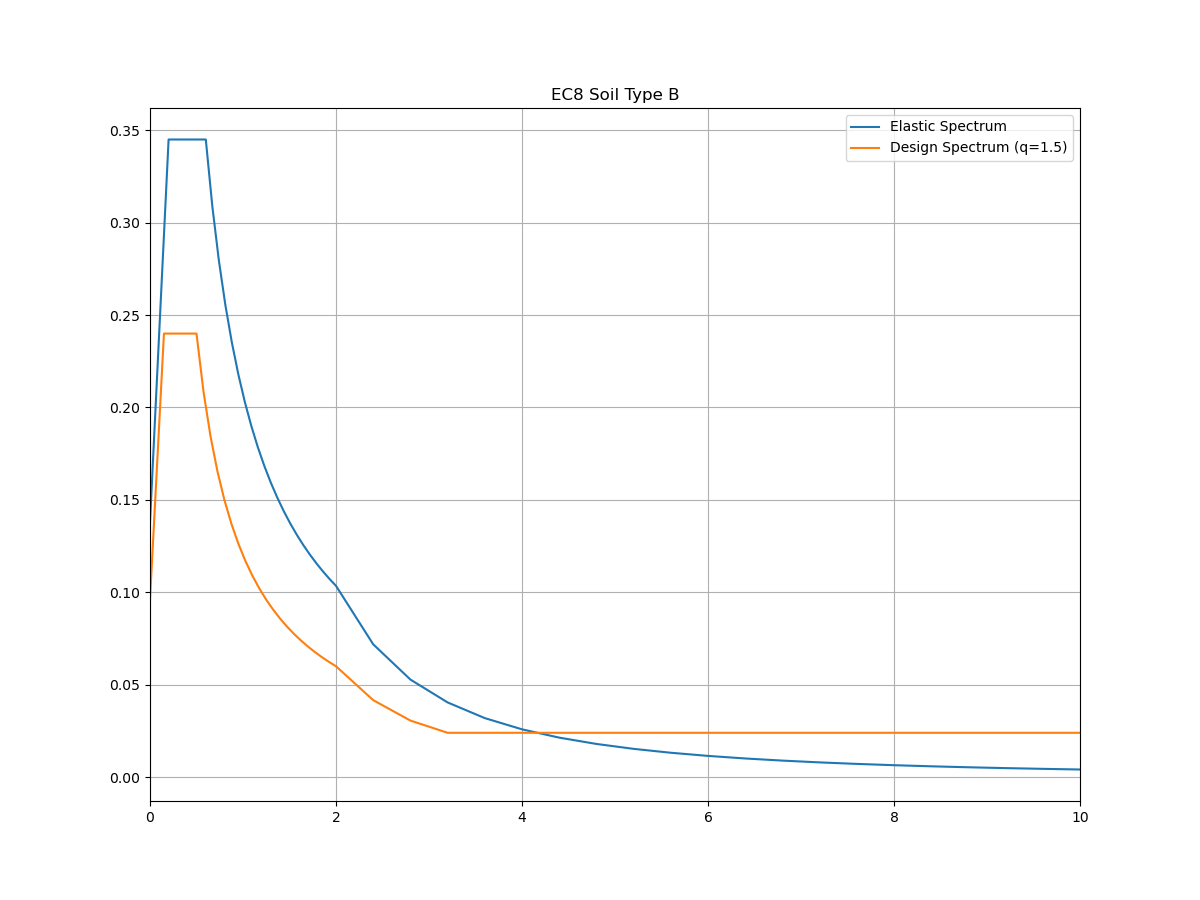

In [11]:
# Plot EC8 Spectra
a_gR = 0.12
site_class = 'C'
get_period_range(0.1, 0.5, 2.0)

# S_d(T, a_gR, soil_type, source_type, importance=1.0, beta=0.2, q=1.5)
s_e = S_e(1.2, 0.12, site_class, 1, importance=1.0, damp=0.05)
s_d = S_d(1.2, 0.12, site_class, 1, importance=1.0, beta=0.2, q=1.5)
print(f's_d is {s_d:.3f}')
T_range, S_range = S_e(None, a_gR, site_class, 1, importance=1.0, damp=0.05)
fig0, ax0 = plt.subplots(figsize=(12,9))
ax0.set_title('EC8 Soil Type B')
ax0.plot(T_range, S_range)
ax0.grid(True)
ax0.set_xlim(left=0, right=10)
T_range, S_range = S_d(None, 0.12, 'B', 1, importance=1.0, beta=0.2, q=1.5)
ax0.plot(T_range, S_range) 
ax0.legend(['Elastic Spectrum','Design Spectrum (q=1.5)']) ;


In [12]:
#from typing import Union, Any, Optional, cast

#reveal_type(((3.5,1.2), (3.5,1.2)))

# New Code Plotting Functions

In [13]:
# Import the plotting package
import matplotlib.pyplot as plt

In [14]:
# Install and import ipympl:
#!pip install ipympl
#import ipympl

In [15]:
# List the available plotting engines
# Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [16]:
# Set the plotting engine
# %matplotlib notebook # can't get this to work
# %matplotlib inline
%matplotlib widget

In [17]:
from csv import writer 

def tick_steps(a, scales = (1, 2, 4, 5, 10)):
    """"""
    d, m = (1, 0) if a==0 else divmod(log10(a),1) 
    for i in scales:
        log_i = log10(i)
        if m < log_i:
            break
    step = i * 10**(d-1)
    number = (int(a/step)+1)
    #k = tick * n
    return number, step


def x_lims(num_list):
    """Returns limits for plotting that match the ticks"""
    res = [tick_steps(a) for a in num_list]
    n_max = max(r for r,_ in res)
    return tuple([(0, n_max * step) for _, step in res])


def diagram_colours(colour_map:str, n_c:int, clip:float=0):
  """Colour and linetype settings for the plot_S_p plotting function.

  returns colour and linetype settings for the plot_S_p plotting function
  for discrete maps, it picks sequential colours. For continuous maps (like  
  viridis) it returns out evenly-spaced colours over the whole colour scale.

  Args:
      colour_map: the name (string) of a standard colour map (e.g. 'viridis' or 
      'tab10')
      n_c: numbers of colours to be returned
      clip: a way to cut off colours at the end of the scale which may be 
      too bright

  Returns:
      colour and linetype settings

  """
  cmap = plt.get_cmap(colour_map)  # viridis
  if colour_map.startswith('Paired'):
    return ('-', range(1,2*n_c,2)), ('--', range(0,2*n_c,2))
  elif colour_map.startswith('tab20b') or colour_map.startswith('tab20c'):
    return ('-', range(0,4*n_c,2)), ('--', range(2,4*n_c,2))
  elif colour_map.startswith('tab20'):
    return ('-', range(0,2*n_c,2)), ('--', range(1,2*n_c,2))
  elif cmap.N < 19:
    return ('-', range(n_c)), ('--', range(n_c))
  elif cmap.N < 25:
    return ('-', range(0,2*n_c,2)), ('--', range(1,2*n_c,2))
  else:
    x = max(0, clip)
    c_params = [0] if n_c < 2 else [float(i) / (n_c - 1 + x) for i in range(n_c)]
    return ('-', c_params), ('--', c_params)


def plot_S_p(soil_classes=['A', 'B', 'C', 'D'], q=1.5, gamma_ov=1.5, n_pt=10, 
             a_gR=0.12, colour_map='tab10', T_vals=None, I_E=1.0, csvsave=None, **kwargs):
  """Returns the plot tuple (fig, axes) for the design spectrum

  This function simplifies the process of creating plots. 
  Note that kwargs are passed through to the plt.subplots function, which allows
  for more detailed control of the plots  
  
  Args:
    soil classes (list, tuple): a list of characters designating soil types (default is ['A', 'B', 'C', 'D'])
    q (float): force reduction factor (set to 1 to see elastic plots only) (default = 1.5)
    gamma_ov (float): material overstrength factor, section 6.2(3)a (default = 1.5)
    n_pt (integer): number of points per arc on the plot
    a_gR (float): reference ground acceleration (default is 0.12)
    colour_map: colour map used for curves (default is 'viridis') 
    T_vals (list, tuple): periods at which values should be plotted (optional)
    I_E (float): important class (I, II, III or IV) which determines 
          the importance factor, 2.1(3)P & 2.1(4) (default = 1.0), 
          which multiplies a_gR to return a_g
    csvsave (str): filename for csv output
  
  Returns:

  """
  # Set up colour maps
  cmap = plt.get_cmap(colour_map)  # viridis
  n_c = len(soil_classes)
  
  # The following parameters are for setting the chart colours
  (lt1, c_params1), (lt2, c_params2) = diagram_colours(colour_map, n_c)


  T_series = {sc: T_list_gen(sc, n_pt) for sc in soil_classes}
  # S_e is the elastic spectrum, S_p is the plastic spectrum
  S_e_series = {sc:[get_S_e(T, sc, a_gR=a_gR, importance_factor=I_E) 
    for T in T_series[sc]] for sc in soil_classes}
  S_p_series = {sc:[get_S_p(T, sc, a_gR=a_gR, q=q, gamma_ov=gamma_ov, importance_factor=I_E) 
    for T in T_series[sc]] for sc in soil_classes}
  

  # Write data to CSV files
  if csvsave is not None:
      with open(csvsave, 'w') as csvfile:
          csvwriter = writer(csvfile, lineterminator='\n')
          headers = sum([['T', f'Se({sc})'] for sc in soil_classes], []) + \
                      sum([['T', f'Sd({sc}, q={q})'] for sc in soil_classes], [])
          csvwriter.writerow(headers)
          S_lists = sum([[T_series.get(sc), S_e_series.get(sc)] for sc in soil_classes], []) + \
                      sum([[T_series.get(sc), S_p_series.get(sc)] for sc in soil_classes], [])
          [csvwriter.writerow(r) for r in zip(*S_lists)]


  # Generate Plots
  x_lim = kwargs.pop('x_lim', None)
  y_lim = kwargs.pop('y_lim', None)
  
  fig, axes = plt.subplots(**kwargs)
  if q > 1:
    [axes.plot(T_series[sc], S_e_series[sc], lt1, c=cmap(c)) for sc, c in zip(soil_classes, c_params1)]
    [axes.plot(T_series[sc], S_p_series[sc], lt2, c=cmap(c)) for sc, c in zip(soil_classes, c_params2)]
    axes.set_title(f'Horizontal Response Spectrum, 5% Damping' + ('' if I_E==1 else f' (I_E={I_E})'))
    if isinstance(T_vals, (list, tuple)):
        [axes.plot(T_vals, [get_S_e(T_val, sc, a_gR=a_gR, importance_factor=I_E) 
                for T_val in T_vals], 'o', c=cmap(c)) 
            for sc, c in zip(soil_classes, c_params1)]
        [axes.plot(T_vals, [get_S_p(T_val, sc, a_gR=a_gR, q=q, gamma_ov=gamma_ov, importance_factor=I_E) 
                for T_val in T_vals], 'o', c=cmap(c)) 
            for sc, c in zip(soil_classes, c_params2)]
  else:
    [axes.plot(T_series[sc], S_e_series[sc], lt1, c=cmap(c)) for sc, c in zip(soil_classes, c_params1)]
    if isinstance(T_vals, (list, tuple)):
        [axes.plot(T_vals, [get_S_e(T_val, sc, a_gR=a_gR) for T_val in T_vals], 'o', c=cmap(c)) 
            for sc, c in zip(soil_classes, c_params1)]
    axes.set_title(f'Unscaled Elastic Horizontal Response Spectrum, 5% Damping')
  axes.legend(labels = soil_classes)
  #axes.title(f'')
  if x_lim is not None:
    axes.set_xlim(x_lim)
  if y_lim is not None:
    axes.set_ylim(y_lim)

  axes.grid(True)
  return fig, axes


def get_S_e_plot_data(soil_class):
  """"""
  T_series = T_list_gen(soil_class)
  S_series = [get_S_e(T, soil_class) for T in T_series]
  return T_series, S_series


def plot_VM(storey_elevs, storey_shears, storey_moments): # HVM_list):
    """"""
    #storey_elevs, storey_shears, storey_moments = zip(*HVM_list)
    max_shear = max(storey_shears)
    max_moment = max(storey_moments)
    
    shear_x_lims, moment_x_lims = x_lims((max_shear, max_moment))
    print(f'Moment: {shear_x_lims}, Shear: {moment_x_lims}')

    shears = shear_coords(tuple(storey_elevs), tuple(storey_shears))
    elevs, shears = zip(*shears)

    fig, ax1 = plt.subplots(figsize=(6,9))

    
    scolor = (0.5, 0.2, 0.1, 0.75)
    scolor1 = (0.5, 0.2, 0.1, 0.9)
    ax1.set_xlabel('Shear (kN)', color=scolor)
    ax1.set_ylabel('Elevation (m)')
    ax1.plot(shears, elevs, color=scolor1)
    ax1.set_xlim(*shear_x_lims)
    ax1.tick_params(axis='x', labelcolor=scolor)
    ax1.set_xticklabels(['{:,.0f}'.format(x) for x in ax1.get_xticks()])
    ax1.grid(True, which='both', axis='y')
    ax1.grid(True, which='major', axis='x', color=scolor)
    
    ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis

    mcolor = (0.1, 0.2, 0.5, 0.75)
    mcolor1 = (0.1, 0.2, 0.5, 0.9)
    ax2.set_xlabel('Moment (kNm)', color=mcolor)  # we already handled the y-label with ax1
    ax2.plot(storey_moments, storey_elevs, color=mcolor1)
    ax2.set_xlim(*moment_x_lims)
    ax2.tick_params(axis='x', labelcolor=mcolor)
    ax2.set_xticklabels(['{:,.0f}'.format(x) for x in ax2.get_xticks()])
    ax2.grid(True, which='major', axis='x', color=mcolor)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [18]:
soil_classes = ('A', 'B', 'C')
n_pt = 10
a_gR = 0.12
I_E = 1.0
gamma_ov = 1.5
q = 1.5

T_series = {sc: T_list_gen(sc, n_pt) for sc in soil_classes}
# S_e is the elastic spectrum, S_p is the plastic spectrum
S_e_series = {sc:[get_S_e(T, sc, a_gR=a_gR, importance_factor=I_E) 
for T in T_series[sc]] for sc in soil_classes}
S_p_series = {sc:[get_S_p(T, sc, a_gR=a_gR, q=q, gamma_ov=gamma_ov, importance_factor=I_E) 
for T in T_series[sc]] for sc in soil_classes}

csvfile = 'csv_out.csv'
if csvfile is not None:
    with open(csvfile, 'w') as csvfile:
        csvwriter = writer(csvfile, lineterminator='\n')
        headers = sum([['T', f'Se({sc})'] for sc in soil_classes], []) + \
                    sum([['T', f'Sd({sc})'] for sc in soil_classes], [])
        csvwriter.writerow(headers)
        S_lists = sum([[T_series.get(sc), S_e_series.get(sc)] for sc in soil_classes], []) + \
                    sum([[T_series.get(sc), S_p_series.get(sc)] for sc in soil_classes], [])
        [csvwriter.writerow(r) for r in zip(*S_lists)]



# Study Example A1

## Geotech / Soils & Hazard

In [19]:
# Geotech - v_s,30
# d_N_pairs = [(10,20),(5,40),(15,60)]
# weathering_soil = True
# d_v_s_pairs = [(d, get_v_s(N,weathering_soil)) for d, N in d_N_pairs]
# print(d_v_s_pairs)
# v_s_30 = get_v_s_30(d_v_s_pairs)
# print(f'v_s_30 = {v_s_30:.2f} m/s')

Text(0, 0.5, 'Base Shear Coefficient')

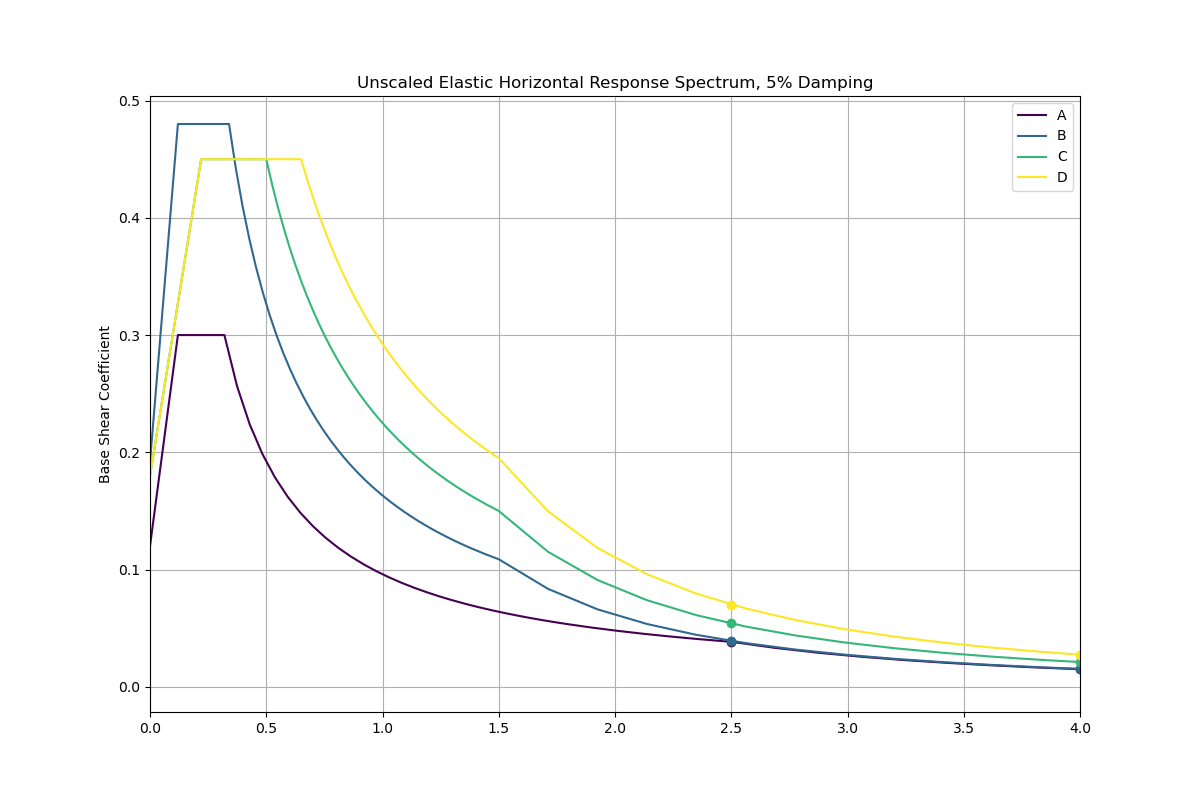

In [20]:
# Plot the elastic spectra by setting q=1 and normalise by setting a_gR to 1.0
fig1, ax1 = plot_S_p(n_pt=40, a_gR=0.12, q=1, T_vals = [2.5, 4.0], colour_map = 'viridis', figsize=(12,8), x_lim=(0,4)) ;
ax1.set_ylabel('Base Shear Coefficient')
# fig1.show() - not needed
# fig1.savefig('HK Spectra.png')

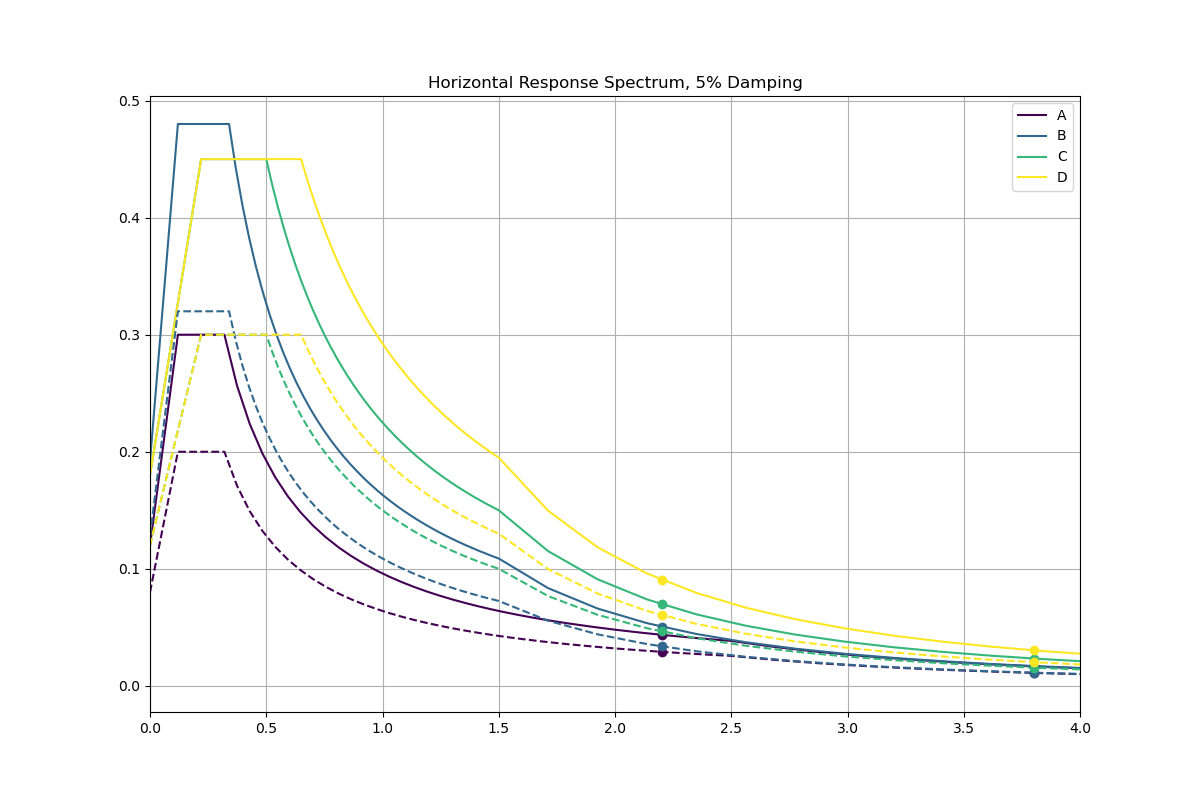

In [21]:
fig2, ax2 = plot_S_p(soil_classes=['A', 'B', 'C', 'D'], n_pt=40, a_gR=0.12, q=1.5, 
                     T_vals = [2.2,3.8], colour_map = 'viridis', figsize=(12,8), x_lim=(0,4)) 
ax1.set_ylabel('Base Shear Coefficient') ;
# fig1.savefig('HK Spectra.png') ;

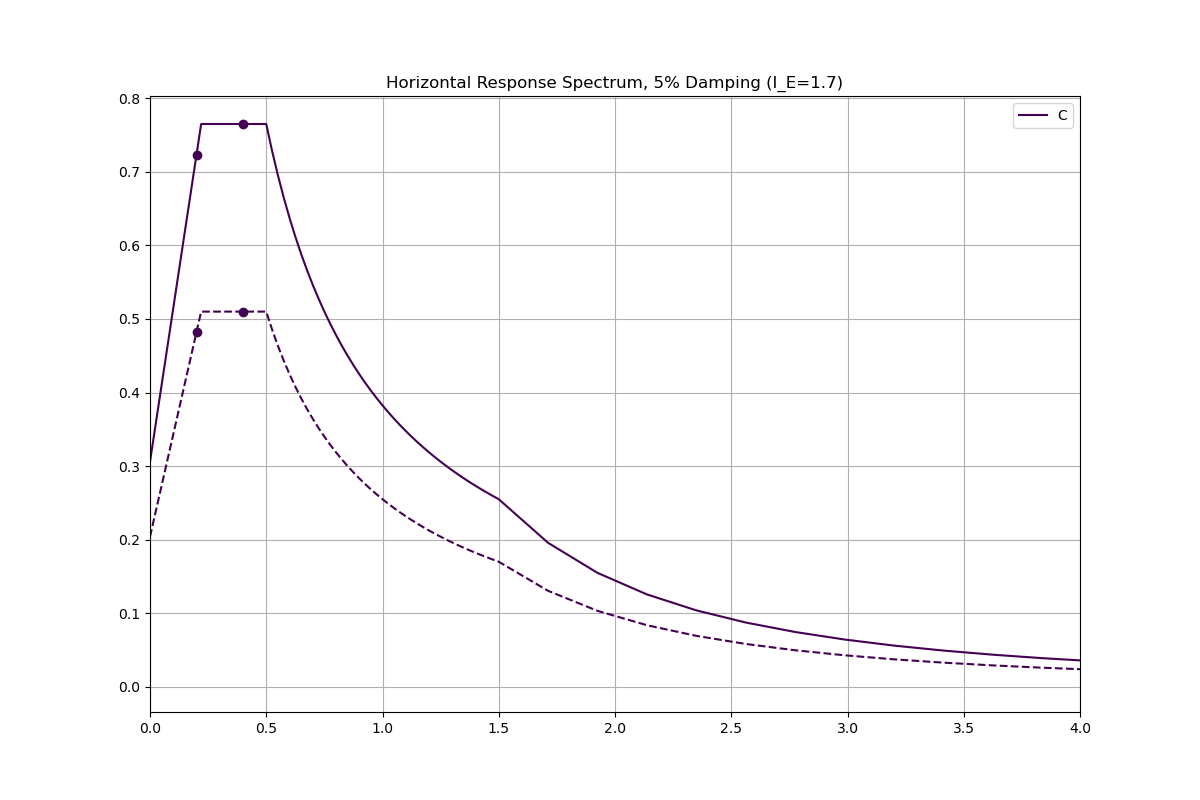

In [22]:
fig2, ax2 = plot_S_p(soil_classes=['C'], n_pt=40, a_gR=0.12, q=1.5, 
                     T_vals = [0.2,0.4], I_E=1.7, colour_map = 'viridis', figsize=(12,8), x_lim=(0,4)) ;

## Building

Importance Factor :   1.40

Based on a drift ratio of H/500, 
T_rayleigh would be 0.27 s

Height is 15.23 m, weight is 41,547 kN, T_code is 0.33 s, S_p is 0.63 g, base shear is 22,248 kN
Base shear coefficient is 53.55%
Storey heights  (m):     0.00 |    1.90 |    4.73 |    4.20 |    4.40
Storey elevs    (m):     0.00 |    1.90 |    6.63 |   10.83 |   15.23
Storey masses  (te):     21.6 | 1,110.1 | 1,248.6 | 1,341.9 |   514.5
Storey weights (kN):      212 |  10,886 |  12,244 |  13,159 |   5,045
Storey forces  (kN):        0 |     266 |   3,638 |  10,433 |   7,911
Storey shears  (kN):   22,248 |  22,248 |  21,983 |  18,344 |   7,911
Storey mom'ts (kNm):  507,169 | 464,897 | 319,153 | 120,485 |       0
Sum of storey forces is 22,248 kN
Moment: (0, 24000.0), Shear: (0, 600000.0)


C:\Users\andrew.mole\AppData\Local\Temp\ipykernel_3524\1725564021.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{:,.0f}'.format(x) for x in ax1.get_xticks()])
C:\Users\andrew.mole\AppData\Local\Temp\ipykernel_3524\1725564021.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['{:,.0f}'.format(x) for x in ax2.get_xticks()])


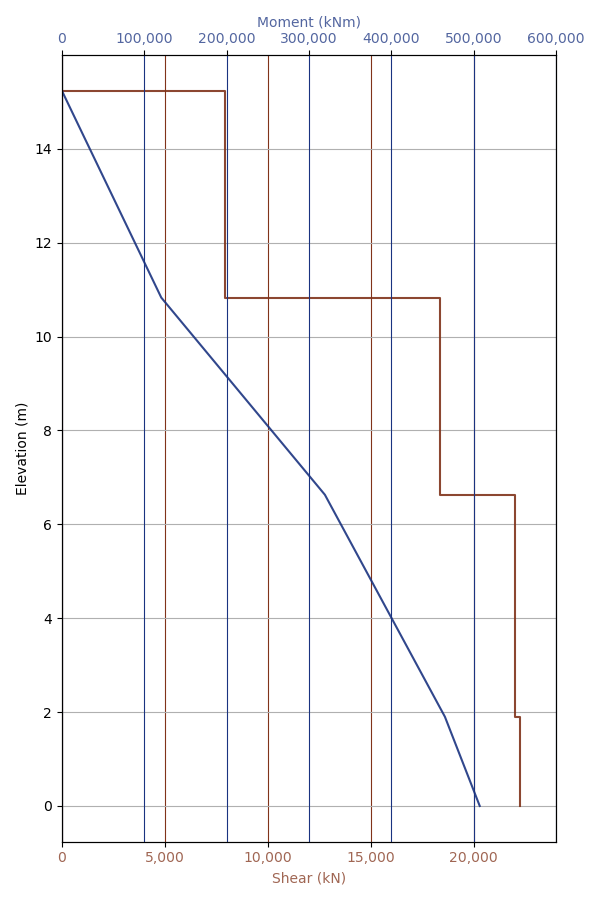

In [23]:
from itertools import accumulate

soil_class = 'C'
importance_class = 'II'   # Ordinary
importance_factor = get_importance_factor(importance_class)
print(f'Importance Factor : {importance_factor:6.2f}')
q = 1.5

storey_heights = [0, 1.9, 4.73, 4.2, 4.4]
storey_elevs = list(accumulate(storey_heights)) # it has to be converted into a list
height = sum(storey_heights)

T_code = get_T_code(height)

storey_masses = [21635.82, 1110116.77, 1248634.24, 1341943.26, 514519.64] # kg
storey_weights = [0.009806 * m for m in storey_masses] # kN
weight = sum(storey_weights)

S_p = get_S_p(T_code, soil_class, importance_factor, q)
base_shear = get_base_shear(weight, S_p)
drift_ratio = 500
print(f'\nBased on a drift ratio of H/{drift_ratio}, ')
print(f'T_rayleigh would be {get_T_rayleigh(storey_weights, delta_R=height/drift_ratio):4.2f} s\n')

print(f'Height is {height:4.2f} m, weight is {weight:4,.0f} kN, T_code is ' + \
      f'{T_code:4.2f} s, S_p is {S_p:4.2f} g, base shear is {base_shear:4,.0f} kN')
print(f'Base shear coefficient is {100 * base_shear / weight:4.2f}%')

storey_forces = get_vertical_force_distribution(base_shear, storey_elevs, storey_weights)
storey_shears, storey_moments = storey_shear_moment(storey_forces, storey_elevs, rev = True)

print('Storey heights  (m): ', ' | '.join([f'{f:7,.2f}' for f in storey_heights]))
print('Storey elevs    (m): ', ' | '.join([f'{f:7,.2f}' for f in storey_elevs]))
print('Storey masses  (te): ', ' | '.join([f'{0.001*f:7,.1f}' for f in storey_masses]))
print('Storey weights (kN): ', ' | '.join([f'{f:7,.0f}' for f in storey_weights]))
print('Storey forces  (kN): ', ' | '.join([f'{f:7,.0f}' for f in storey_forces]))
print('Storey shears  (kN): ', ' | '.join([f'{f:7,.0f}' for f in storey_shears]))
print('Storey mom\'ts (kNm): ', ' | '.join([f'{m:7,.0f}' for m in storey_moments]))

print(f'Sum of storey forces is {sum(storey_forces):4,.0f} kN')

plot_VM(storey_elevs, storey_shears, storey_moments)

In [24]:

T_vals = (0.2, 0.4) # sec

for T_val in T_vals:
    S_p = get_S_p(T_val, soil_class, importance_factor, q)
    base_shear = get_base_shear(weight, S_p)

    print(f'Height is {height:4.2f} m, T is {T_val:4.2f} s, weight is ' + \
          f'{weight:4,.0f} kN, S_p is {S_p:4.2f} g, base shear is {base_shear:4,.0f} kN')
    print(f'Base shear coefficient is {100 * base_shear / weight:4.2f}%')

    storey_forces = get_vertical_force_distribution(base_shear, storey_elevs, storey_weights)
    storey_shears, storey_moments = storey_shear_moment(storey_forces, storey_elevs, rev = True)

    print('Storey heights  (m): ', ' | '.join([f'{h:7,.2f}' for h in storey_heights]))
    print('Storey elevs    (m): ', ' | '.join([f'{h:7,.2f}' for h in storey_elevs]))
    print('Storey weights (kN): ', ' | '.join([f'{f:7,.0f}' for f in storey_weights]))
    print('Storey forces  (kN): ', ' | '.join([f'{f:7,.0f}' for f in storey_forces]))
    print('Storey shears  (kN): ', ' | '.join([f'{f:7,.0f}' for f in storey_shears]))
    print('Storey mom\'ts (kNm): ', ' | '.join([f'{m:7,.0f}' for m in storey_moments]))

    print(f'Sum of storey forces is {sum(storey_forces):4,.0f} kN\n')





Height is 15.23 m, T is 0.20 s, weight is 41,547 kN, S_p is 0.60 g, base shear is 21,035 kN
Base shear coefficient is 50.63%
Storey heights  (m):     0.00 |    1.90 |    4.73 |    4.20 |    4.40
Storey elevs    (m):     0.00 |    1.90 |    6.63 |   10.83 |   15.23
Storey weights (kN):      212 |  10,886 |  12,244 |  13,159 |   5,045
Storey forces  (kN):        0 |     251 |   3,440 |   9,864 |   7,479
Storey shears  (kN):   21,035 |  21,035 |  20,783 |  17,344 |   7,479
Storey mom'ts (kNm):  479,505 | 439,539 | 301,745 | 113,913 |       0
Sum of storey forces is 21,035 kN

Height is 15.23 m, T is 0.40 s, weight is 41,547 kN, S_p is 0.63 g, base shear is 22,248 kN
Base shear coefficient is 53.55%
Storey heights  (m):     0.00 |    1.90 |    4.73 |    4.20 |    4.40
Storey elevs    (m):     0.00 |    1.90 |    6.63 |   10.83 |   15.23
Storey weights (kN):      212 |  10,886 |  12,244 |  13,159 |   5,045
Storey forces  (kN):        0 |     266 |   3,638 |  10,433 |   7,911
Storey shears  

# Example 2

* Top of building is at 193 mPD
* Top of transfer is at 47 mPD
* Top of pile cap is at 6 mPD (assumed)

In [25]:
height_m = 193 - 6
print(f'EC8 empirical building period = {get_period_EC8(height_m):4.2f} secs')
print(f'HK empirical building period = {get_T_code(height_m):4.2f} secs')

EC8 empirical building period = 2.53 secs
HK empirical building period = 4.07 secs


sx at 4.682 secs is 0.013g
sy at 3.698 secs is 0.020g
s_hk at 4.07 secs is 0.014g


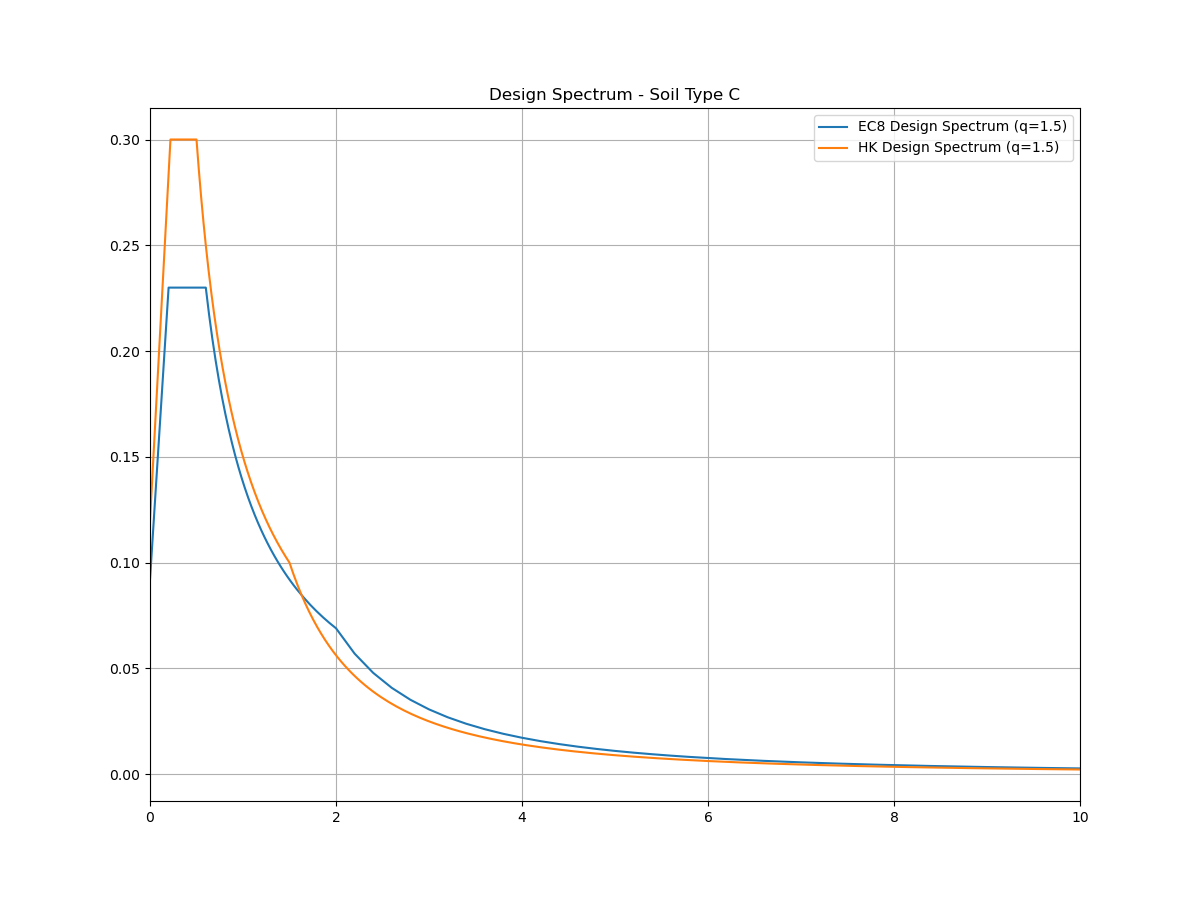

In [29]:
# Plot EC8 Spectra
tower, Tx, Ty  = 'Tower 1', 4.682, 3.698
# tower, Tx, Ty  = 'Tower 8', 5.342, 3.828

a_gR = 0.12
site_class = 'C'
get_period_range(0.1, 0.5, 2.0)
T_1 = 4.07  # secs
# Tx = 5.342  # secs
# Ty = 3.828  # secs
I_E = 1.0
gamma_ov = 1.5
q = 1.5
beta = 0
source_type = 1

# HK Code
sc = ['C']
n_pt = 200
T_series = {sc: T_list_gen(sc, n_pt) for sc in soil_classes}
# S_e is the elastic spectrum, S_p is the plastic spectrum
S_e_series = {sc:[get_S_e(T, sc, a_gR=a_gR, importance_factor=I_E) 
for T in T_series[sc]] for sc in soil_classes}
S_p_series = {sc:[get_S_p(T, sc, a_gR=a_gR, q=q, gamma_ov=gamma_ov, importance_factor=I_E) 
for T in T_series[sc]] for sc in soil_classes}


# S_d(T, a_gR, soil_type, source_type, importance=1.0, beta=0.2, q=1.5)
# s_e = S_e(T_1, a_gR, site_class, source_type, importance=1.0, damp=0.05)
# s_d = S_d(T_1, a_gR, site_class, source_type, importance=1.0, beta=beta, q=1.5)
sx = S_d(Tx, a_gR, site_class, source_type, importance=1.0, beta=beta, q=q)
sy = S_d(Ty, a_gR, site_class, source_type, importance=1.0, beta=beta, q=q)
s_hk = get_S_p(T_1, sc[0], a_gR=a_gR, q=q, gamma_ov=gamma_ov, importance_factor=I_E)
# s_hk5 = get_S_p(5, sc[0], a_gR=a_gR, q=q, gamma_ov=gamma_ov, importance_factor=I_E)
# print(f's_e is {s_e:.3f}g')
# print(f's_d is {s_d:.3f}g')
print(f'sx at {Tx} secs is {sx:.3f}g')
print(f'sy at {Ty} secs is {sy:.3f}g')
print(f's_hk at {T_1} secs is {s_hk:.3f}g')
# print(f's_hk5 is {s_hk5:.3f}g')
# T_range, S_range = S_e(None, a_gR, site_class, source_type, importance=1.0, damp=0.05)
fig0, ax0 = plt.subplots(figsize=(12,9))
ax0.set_title(f'Design Spectrum - Soil Type {site_class}')
# ax0.set_title(f'{tower} - Soil Type {site_class}')
# ax0.plot(T_range, S_range)
ax0.grid(True)
ax0.set_xlim(left=0, right=10)
T_range, S_range = S_d(None, a_gR, site_class, source_type, importance=I_E, beta=beta, q=q, n_pt=40)
ax0.plot(T_range, S_range)
ax0.plot(T_series.get(site_class), S_p_series.get(site_class))
# ax0.plot(T_1, s_e,'o') 
# ax0.plot(T_1, s_d,'o') 
# ax0.plot(Tx, sx,'o') 
# ax0.plot(Ty, sy,'o') 
# ax0.plot(T_1, s_hk,'o') 
# ax0.legend(['EC8 Elastic Spectrum','EC8 Design Spectrum (q=1.5)','HK Design Spectrum (q=1.5)']) ;
ax0.legend([f'EC8 Design Spectrum (q={q})',f'HK Design Spectrum (q={q})',]) ;

# csvsave = 'EC8_class_C_HK.csv'
csvsave = None
# Write data to CSV files
if csvsave is not None:
    with open(csvsave, 'w') as csvfile:
        csvwriter = writer(csvfile, lineterminator='\n')
        headers = ['T','Sa']
        csvwriter.writerow(headers)
        S_lists = [T_range, S_range]
        [csvwriter.writerow(r) for r in zip(*S_lists)]

# csvsave = 'HK_class_C.csv'
# Write data to CSV files
if csvsave is not None:
    with open(csvsave, 'w') as csvfile:
        csvwriter = writer(csvfile, lineterminator='\n')
        headers = ['T','Sa']
        csvwriter.writerow(headers)
        S_lists = [T_series.get(site_class), S_p_series.get('C')]
        [csvwriter.writerow(r) for r in zip(*S_lists)]

# fig0.savefig(f'{tower}_class_C_HK.svg')
# fig0.savefig(f'{tower}_class_C_HK.png')
fig0.savefig(f'general_class_C_HK.svg')
fig0.savefig(f'general_class_C_HK.png')

In [44]:
from itertools import accumulate
# Building Check

soil_class = 'C'
importance_class = 'III'   # Ordinary (HK)
importance_factor = get_importance_factor(importance_class)
print(f'Importance Factor : {importance_factor:6.2f}')
q = 1.5

storey_heights = [0, 1.9, 4.73, 4.2, 4.4]
storey_elevs = list(accumulate(storey_heights))    #  it has to be converted into a list
height = sum(storey_heights)

T_code = get_T_code(height)

storey_masses = [21635.82, 1110116.77, 1248634.24, 1341943.26, 514519.64]    #   kg
storey_weights = [0.009806 * m for m in storey_masses]    #   kN
weight = sum(storey_weights)



Importance Factor :   1.00


# Example 3

In [ ]:
importance_class = 'II'
d_N_pairs = [(10,20),(5,40),(15,60)]
weathering_soil = True
d_v_s_pairs = [(d, get_v_s(N,weathering_soil)) for d, N in d_N_pairs]
print(d_v_s_pairs)
v_s_30 = get_v_s_30(d_v_s_pairs)
print(f'v_s_30 = {v_s_30:.2f} m/s')

[(10, 253.72107471103072), (5, 305.93885793667306), (15, 341.3337885292727)]
v_s_30 = 300.90 m/s


In [ ]:
d_v = sum(d/v for d,v in d_v_s_pairs)
d_v

0.09970174848374219

In [ ]:
30/d_v

300.897431150788

In [ ]:
[get_S_e(0.3, st, a_gR = 1.0) for st in ['A','B','C','D']]

[2.5, 4.0, 3.75, 3.75]

In [ ]:
T_list_gen('D', 11)

[0.0,
 0.02,
 0.04,
 0.060000000000000005,
 0.08,
 0.1,
 0.12000000000000001,
 0.14,
 0.16,
 0.18,
 0.2,
 0.22,
 0.2590909090909091,
 0.2981818181818182,
 0.3372727272727273,
 0.3763636363636364,
 0.41545454545454547,
 0.45454545454545453,
 0.4936363636363636,
 0.5327272727272727,
 0.5718181818181819,
 0.6109090909090908,
 0.65,
 0.7272727272727273,
 0.8045454545454547,
 0.8818181818181817,
 0.9590909090909091,
 1.0363636363636364,
 1.1136363636363635,
 1.190909090909091,
 1.268181818181818,
 1.3454545454545455,
 1.4227272727272728,
 1.5,
 2.272727272727273,
 3.0454545454545454,
 3.8181818181818183,
 4.590909090909091,
 5.363636363636363,
 6.136363636363637,
 6.909090909090909,
 7.681818181818182,
 8.454545454545455,
 9.227272727272727,
 10]

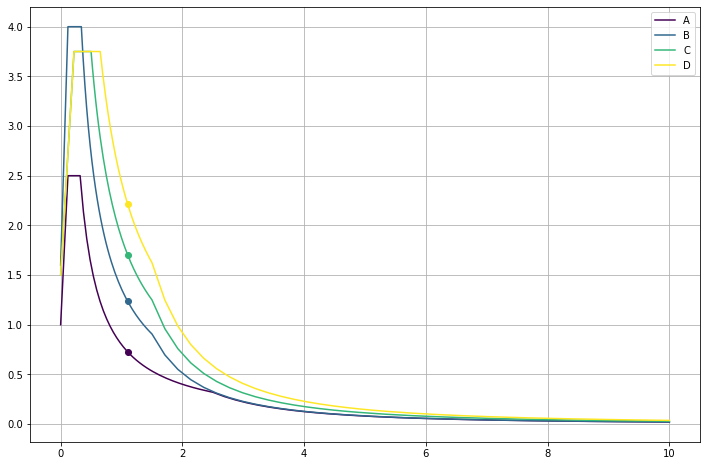

In [ ]:
# Plot the elastic spectra by setting q=1
fig1, ax1 = plot_S_p(n_pt=40, a_gR=1.0, q=1, T_val = 1.1, colour_map = 'viridis', figsize=(12,8)) ;# fig1.show() - not needed

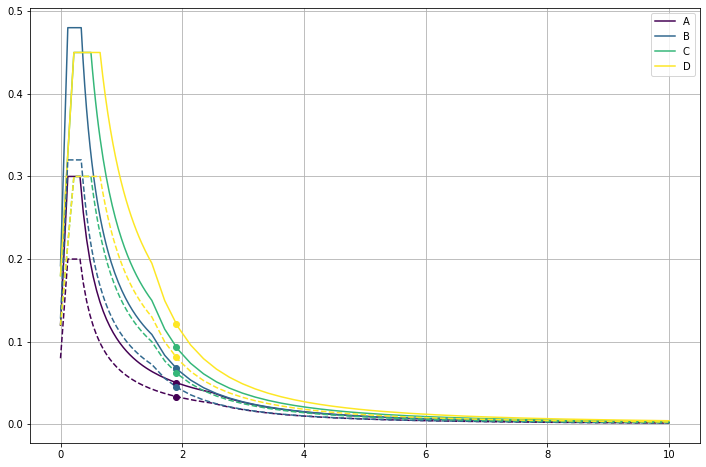

In [ ]:
fig2, ax2 = plot_S_p(soil_classes=['A', 'B', 'C', 'D'], n_pt=40, a_gR=0.12, q=1.5, 
                     T_val = 1.9, colour_map = 'viridis', figsize=(12,8)) ;

## Sample Building

Assume a rectangular prism, 23m tall, base 30x50
Assume floor heights to be 5.5m at lowest level, then 3.5m above that

Static forces only

Assume:
* soil class = 'D'
* importance class 'II'
* a_gR is 0.12g
* q is 1.5

In [ ]:
from itertools import accumulate
bx, by = 50, 30
soil_class = 'D'
importance_class = 'II'
importance_factor = get_importance_factor(importance_class)
q = 1.5
w_sm = 0.35 * 25 + 1.0 + 0.4 + 0.25 * 4
print(f'Seismic weight per square metre is {w_sm:4.2f} kN/m^2')
storey_heights = [0, 5.5] + [3.5]*5
storey_elevs = list(accumulate(storey_heights)) # for some reason it has to be converted into a list
height = sum(storey_heights)
#print('storey_elevs', list(storey_elevs))
T_code = get_T_code(height)

storey_weights = [w_sm * bx * by for _ in storey_heights]
#storey_weights = [w_sm * bx * by for bx, by in zip(bx_list, by_list)]
weight = sum(storey_weights)

S_p = get_S_p(T_code, soil_class, importance_factor, q)
base_shear = get_base_shear(weight, S_p)
print(f'T_rayleigh is {get_T_rayleigh(storey_weights, delta_R=height/500):4.2f} s')

print(f'Height is {height:4.2f} m, weight is {weight:4,.0f} kN, T_code is {T_code:4.2f} s, S_p is {S_p:4.2f} g, base shear is {base_shear:4,.0f} kN')

storey_forces = get_vertical_force_distribution(base_shear, storey_elevs, storey_weights)

sum(storey_heights), storey_heights, list(storey_elevs), storey_weights, [f'{f:4,.0f}' for f in storey_forces], f'{sum(storey_forces):4,.0f} kN'

Seismic weight per square metre is 11.15 kN/m^2
T_rayleigh is 0.33 s
Height is 23.00 m, weight is 117,075 kN, T_code is 0.50 s, S_p is 0.63 g, base shear is 62,694 kN


(23.0,
 [0, 5.5, 3.5, 3.5, 3.5, 3.5, 3.5],
 [0, 5.5, 9.0, 12.5, 16.0, 19.5, 23.0],
 [16725.0, 16725.0, 16725.0, 16725.0, 16725.0, 16725.0, 16725.0],
 ['   0', '1,324', '3,544', '6,837', '11,202', '16,639', '23,148'],
 '62,694 kN')

In [ ]:
[[round(get_T_rayleigh(base_shear, delta_R=delta_R), 3) for base_shear in [117_075, 200_075]] for delta_R in [0.023, 0.046]]

[[0.233, 0.233], [0.33, 0.33]]

In [ ]:
delta_R = 0.046
storey_deflections = [delta_R / height * se for se in storey_elevs]
storey_deflections

[0.0, 0.011, 0.018000000000000002, 0.025, 0.032, 0.039, 0.046]

In [ ]:
[round(get_T_rayleigh(storey_weights, storey_deflections=storey_deflections), 4) for base_shear in [117_075, 200_075]]

[0.33, 0.33]

In [17]:
text = 'aa,bb,cc'
'1. {0}, 2. {1}, 3. {2}'.format(*text.split(','))


'1. aa, 2. bb, 3. cc'

In [20]:
a_list = ['a','b','c']
a_list.append('d')
a_list

['a', 'b', 'c', 'd']

In [22]:
a_list = ['a','b','c']
a_list.extend(['d','e'])
# a_list